<a href="https://colab.research.google.com/github/jeong1suk/ObjectDetection/blob/main/fasterrcnn_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip DRIVING-DATASET.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Detection/train/a68c64c8fc996e2f.jpg  
  inflating: Detection/train/a68e2c3746b43efe.jpg  
  inflating: Detection/train/a6919da5b27eab7c.jpg  
  inflating: Detection/train/a69229cf87bd0c1a.jpg  
  inflating: Detection/train/a6936ea349360dda.jpg  
  inflating: Detection/train/a69782378ab216fa.jpg  
  inflating: Detection/train/a69f6ee5964a59b1.jpg  
  inflating: Detection/train/a6a015f4dffec6ab.jpg  
  inflating: Detection/train/a6a7516de40fbc05.jpg  
  inflating: Detection/train/a6aa310bd8eea104.jpg  
  inflating: Detection/train/a6aadcf43f4ca464.jpg  
  inflating: Detection/train/a6b383c75e535cac.jpg  
  inflating: Detection/train/a6b4621118e8e034.jpg  
  inflating: Detection/train/a6c61a6228e7cbbc.jpg  
  inflating: Detection/train/a6cf70fe15323a12.jpg  
  inflating: Detection/train/a6d181b95bd96a0e.jpg  
  inflating: Detection/train/a6d26d8ed4ece82b.jpg  
  inflating: Detection/train/a6d51dffa95226cc.jpg  
  inflating: Detection/train

'Data_tensor_transform.ipynb' 에서 작성했던 코드를 그대로 가져왔다.

In [2]:
import torch
import pandas as pd
import numpy as np
import os
import cv2

In [3]:
CLASS_NAME_TO_ID = {'Bus': 0, 'Truck': 1}
CLASS_ID_TO_NAME = {0: 'Bus', 1: 'Truck'}

In [4]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith("jpg")]
        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # input : image
        # tagget : label (box, class_id)
        # get_image -> filiname(imageId) -> get_label
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        img_H, img_W, _ = image.shape
        if self.transformer:
            # image shape: (H, W, C)
            # tensor hspa: (C, H, W)
            image = self.transformer(image)
            _, img_H, img_W = image.shape

        bboxes[:, [0,2]] *= img_W
        bboxes[:, [1,3]] *= img_H
        # bboxes = [[xmin, ymin, xmax, ymax]] -> [0,2]:xmin, xmax / [1,3]: ymin, ymax

        target = {}
        target["boxes"] = torch.Tensor(bboxes).float()
        target["labels"] = torch.Tensor(class_ids).long()

        return image, target, filename

    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image

    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.data_df[self.data_df['ImageID'] == image_id]
        cate_names = meta_data["LabelName"].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])
        bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values
        bboxes[:, [1,2]] = bboxes[:, [2,1]]
        return bboxes, class_ids

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for a, b, c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return image_list, target_list, filename_list

In [7]:
def build_dataloader(data_dir, batch_size=4, image_size=448):
    transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(image_size, image_size)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = Detection_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

data_dir = "./Detection/"
dloaders = build_dataloader(data_dir, batch_size=4, image_size=448)

for phase in ["train", "val"]:
    for index, batch in enumerate(dloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(f"{phase} - {targets}")
        print({f"{phase} - {filenames}"})
        if index == 0:
            break

train - [{'boxes': tensor([[ 97.7200,  48.5269, 375.7600, 401.0258],
        [407.6800,  50.0797, 419.1600,  67.9374]]), 'labels': tensor([1, 1])}, {'boxes': tensor([[157.6400, 216.9265, 337.9600, 344.2526]]), 'labels': tensor([1])}, {'boxes': tensor([[ 56.0000, 146.7200, 437.9200, 447.6268]]), 'labels': tensor([0])}, {'boxes': tensor([[  0.0000, 264.3200,  55.2617, 297.9200],
        [ 55.2617, 148.6800, 447.5780, 328.4400]]), 'labels': tensor([0, 0])}]
{"train - ['b02f159f80ad6c88.jpg', 'c67a05032b0cb239.jpg', '76c891fe44e13c56.jpg', 'b9ec048cf7ee64a5.jpg']"}
val - [{'boxes': tensor([[ 24.0800,  88.6753, 394.5200, 368.5705],
        [424.7600, 162.6415, 447.7200, 359.3247]]), 'labels': tensor([1, 1])}]
{"val - ['fd53ec028ad4acb9.jpg']"}


# Faster RCNN 아키텍쳐 불러오기

In [8]:
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [9]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 84.5MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
in_features

1024

In [11]:
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
def build_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [14]:
NUM_CLASSES = 2
model = build_model(num_classes=NUM_CLASSES)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Detector 학습

In [15]:
phase = 'train'
model.train()

for index, batch in enumerate(dloaders[phase]):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    loss = model(images, targets)

    if index==0:
        break

In [16]:
loss

{'loss_classifier': tensor(0.4634, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0371, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2335, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0157, grad_fn=<DivBackward0>)}

In [17]:
from collections import defaultdict

m1 mac을 사용하기 때문에 'mps'를 사용.

In [18]:
data_dir = "./Detection/"
# is_mps = True
is_cuda = True

NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 6
VERBOSE_FREQ = 200
# DEVICE = torch.device('mps' if torch.backends.mps.is_available() and is_mps else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

In [19]:
DEVICE

device(type='cuda')

## train_one_epoch
* train과 validation 모두 수행
* loss:
    * classifier loss
    * box regression loss
    * objectness loss
    * RPN box regression loss
* 최적화 및 모델 업데이트

In [24]:
from collections import defaultdict

def train_one_epoch(dataloaders, model, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)

    model.train()

    for phase in ["train", "val"]:
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0]
            targets = batch[1]
            filenames = batch[2]

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.set_grad_enabled(phase == "train"):
                loss = model(images, targets)
            total_loss = sum(each_loss for each_loss in loss.values())

            if phase == "train":
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                if (index > 0) and (index % VERBOSE_FREQ) == 0:
                    text = f"{index}/{len(dataloaders[phase])} - "
                    for k, v in loss.items():
                        text += f"{k}: {v.item():.4f}  "
                    print(text)

                for k, v in loss.items():
                    train_loss[k] += v.item()
                train_loss["total_loss"] += total_loss.item()

            else:
                for k, v in loss.items():
                    val_loss[k] += v.item()
                val_loss["total_loss"] += total_loss.item()

    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders["train"])
        val_loss[k] /= len(dataloaders["val"])
    return train_loss, val_loss

In [21]:
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
model = build_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
def save_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [25]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"epoch:{epoch+1}/{num_epochs} - Train loss: {train_loss['total_loss']:.4f}, Val loss: {val_loss['total_loss']:.4f}")

    if (epoch+1) % 10 == 0:
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

200/2284 - loss_classifier: 0.0297  loss_box_reg: 0.0212  loss_objectness: 0.0082  loss_rpn_box_reg: 0.0028  
400/2284 - loss_classifier: 0.0438  loss_box_reg: 0.0682  loss_objectness: 0.0123  loss_rpn_box_reg: 0.0213  
600/2284 - loss_classifier: 0.0330  loss_box_reg: 0.0322  loss_objectness: 0.0344  loss_rpn_box_reg: 0.0037  
800/2284 - loss_classifier: 0.0504  loss_box_reg: 0.0704  loss_objectness: 0.1210  loss_rpn_box_reg: 0.0160  
1000/2284 - loss_classifier: 0.0786  loss_box_reg: 0.0800  loss_objectness: 0.0181  loss_rpn_box_reg: 0.0025  
1200/2284 - loss_classifier: 0.0204  loss_box_reg: 0.0280  loss_objectness: 0.0075  loss_rpn_box_reg: 0.0021  
1400/2284 - loss_classifier: 0.0781  loss_box_reg: 0.0588  loss_objectness: 0.0079  loss_rpn_box_reg: 0.0033  
1600/2284 - loss_classifier: 0.0529  loss_box_reg: 0.0519  loss_objectness: 0.0083  loss_rpn_box_reg: 0.0090  
1800/2284 - loss_classifier: 0.0248  loss_box_reg: 0.0061  loss_objectness: 0.0093  loss_rpn_box_reg: 0.0046  
2000/

KeyboardInterrupt: 

In [26]:
tr_loss_classifier = []
tr_loss_box_reg = []
tr_loss_objectness = []
tr_loss_rpn_box_reg = []
tr_loss_total = []

for tr_loss in train_losses:
    tr_loss_classifier.append(tr_loss['loss_classifier'])
    tr_loss_box_reg.append(tr_loss['loss_box_reg'])
    tr_loss_objectness.append(tr_loss['loss_objectness'])
    tr_loss_rpn_box_reg.append(tr_loss['loss_rpn_box_reg'])
    tr_loss_total.append(tr_loss['total_loss'])

val_loss_classifier = []
val_loss_box_reg = []
val_loss_objectness = []
val_loss_rpn_box_reg = []
val_loss_total = []

for vl_loss in val_losses:
    val_loss_classifier.append(vl_loss['loss_classifier'])
    val_loss_box_reg.append(vl_loss['loss_box_reg'])
    val_loss_objectness.append(vl_loss['loss_objectness'])
    val_loss_rpn_box_reg.append(vl_loss['loss_rpn_box_reg'])
    val_loss_total.append(vl_loss['total_loss'])

In [27]:
import matplotlib.pyplot as plt

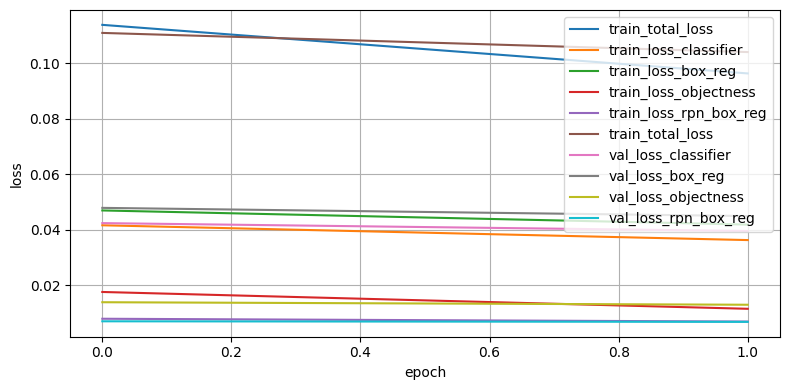

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(tr_loss_total, label="train_total_loss")
plt.plot(tr_loss_classifier, label="train_loss_classifier")
plt.plot(tr_loss_box_reg,  label="train_loss_box_reg")
plt.plot(tr_loss_objectness, label="train_loss_objectness")
plt.plot(tr_loss_rpn_box_reg,  label="train_loss_rpn_box_reg")

plt.plot(val_loss_total, label="train_total_loss")
plt.plot(val_loss_classifier, label="val_loss_classifier")
plt.plot(val_loss_box_reg,  label="val_loss_box_reg")
plt.plot(val_loss_objectness, label="val_loss_objectness")
plt.plot(val_loss_rpn_box_reg,  label="val_loss_rpn_box_reg")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()